In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder
import time

Use LOF and Isolation forest to find anomalies. At the end, I ended up using only anomalies flagged by Isolation forest for my further analysis

In [2]:
df_contract = pd.read_csv("contract_eng_consolidated.csv")
df_project = pd.read_csv('project_eng_consolidated_with_topics.csv')

C:\Users\v-krvibh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [185]:
def find_columns_with_null(df):
    null_columns = df.columns[df.isnull().any()]
    return null_columns 

def find_null_columns_value(df):
    null_columns = find_columns_with_null(df)
    return df[null_columns].isnull().sum()
    
def find_column_percent_null(df):
    null_columns = find_columns_with_null(df)
    null_columns_percent = df[null_columns].isnull().sum()/len(df)
    return null_columns_percent

In [3]:
print(df_project.columns)
print(df_project.shape)

Index(['project_type_name_eng', 'purchase_method_group_name_eng',
       'province_eng', 'project_status_eng', 'district_eng',
       'announce_date_eng', 'transaction_date_eng', 'project_money_cleaned',
       'price_build_cleaned', 'sum_price_agree_cleaned', 'dept_name_eng',
       'budget_year_cleaned', 'project_id', 'project_name', 'geom',
       'dept_name_group', 'Topic_group'],
      dtype='object')
(401219, 17)


In [4]:
for i in df_project.columns:
    print(i, df_project[i].nunique())

project_type_name_eng 8
purchase_method_group_name_eng 11
province_eng 78
project_status_eng 2
district_eng 897
announce_date_eng 1495
transaction_date_eng 1660
project_money_cleaned 114553
price_build_cleaned 180204
sum_price_agree_cleaned 143179
dept_name_eng 17977
budget_year_cleaned 5
project_id 400988
project_name 375355
geom 53338
dept_name_group 7
Topic_group 20


In [5]:
df_project['purchase_method_group_name_eng'].unique()

array(['Bidding', 'E-bidding', 'Special', 'Hire consultants',
       'Special cases', 'Price examination', 'Agreed price', 'E-market',
       'Hire to design', 'selection', 'Specific'], dtype=object)

In [6]:
### drop category that have less than 0.1% of the total row count
df_project.drop(df_project[df_project['project_type_name_eng'] == 'Hire to design'].index, inplace=True)
df_project.drop(df_project[df_project['project_type_name_eng'] == 'Hire to design and supervise'].index, inplace=True)
df_project.drop(df_project[df_project['project_type_name_eng'] == 'Hire to supervise'].index, inplace=True)

df_project.drop(df_project[df_project['purchase_method_group_name_eng'] == 'Bidding'].index, inplace=True)
df_project.drop(df_project[df_project['purchase_method_group_name_eng'] == 'Agreed price'].index, inplace=True)
df_project.drop(df_project[df_project['purchase_method_group_name_eng'] == 'E-market'].index, inplace=True)
df_project.reset_index(drop=True,inplace = True)

In [7]:
### delete columns that have too many unique categorical values
detector_data = df_project.drop(columns=['province_eng','district_eng','announce_date_eng','transaction_date_eng','project_money_cleaned'])
detector_data.drop(columns=['geom','project_id','price_build_cleaned','dept_name_eng','project_name','budget_year_cleaned'],inplace = True)

In [8]:
detector_data.dtypes

project_type_name_eng             object
purchase_method_group_name_eng    object
project_status_eng                object
sum_price_agree_cleaned            int64
dept_name_group                   object
Topic_group                        int64
dtype: object

In [9]:
### standard scale numeric col
### turn string col to onehot

# Select numerical columns
#numerical_cols = [cname for cname in df_project.columns if 
#                df_project[cname].dtype in ['int64', 'float64']]

numerical_cols = ['sum_price_agree_cleaned']

In [10]:
categorical_cols = [cname for cname in detector_data.columns if
                    detector_data[cname].nunique() < 12 and 
                    detector_data[cname].dtype == "object"]
categorical_cols.append('Topic_group')

In [11]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) #handle_unknown='ignore': if test has that new feature, ignore it
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(detector_data[categorical_cols]))

In [12]:
OH_cols_train.index = df_project.index

In [13]:
OH_cols_train.columns = OH_encoder.get_feature_names()

In [14]:
OH_cols_train

,x0_Hire consultants,x0_Hire for construction,x0_Outsourcing / Contracting services,x0_buy,x0_rent,x1_E-bidding,x1_Hire consultants,x1_Price examination,x1_Special,x1_Special cases,...,x4_10,x4_11,x4_12,x4_13,x4_14,x4_15,x4_16,x4_17,x4_18,x4_19
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397339,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397340,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397341,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397342,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
X = pd.concat([detector_data[numerical_cols], OH_cols_train.reset_index(drop=True)], axis=1)

In [102]:
current = time.time()


outlier_detect = IsolationForest(n_estimators=100, max_samples=0.8, contamination=.001,max_features = 0.8, random_state = 4) 
# might need to change max features

outliers_predicted = outlier_detect.fit_predict(X)
now = time.time()
print(now- current, 'seconds')


96.80292916297913 seconds


In [103]:
outliers_predicted[outliers_predicted==-1].shape

(398,)

In [18]:
df_project['iForest_outlier'] = outliers_predicted

In [310]:
df_project.to_csv('anomaly_model_v4.csv',index=False)

In [318]:
temp = outlier_detect.decision_function(X)

In [313]:
outliers_predicted[1:3]

array([-1,  1])

In [169]:
'''
In practice,taking n_neighbors=20 appears to work well in general. When the proportion of outliers is high 
(i.e. greater than 10 %, as in the example below), n_neighbors should be greater (n_neighbors=35 in the example below). 
how isolated it is with respect to the surrounding neighborhood.
'''

#current = time.time()
#LOF = LocalOutlierFactor(n_neighbors=20,contamination = 0.001)
#y_pred = LOF.fit_predict(X)
#now = time.time()
#print(now- current, 'seconds')

41.6827597618103 seconds


In [170]:
#df_project['LOF_outlier'] = y_pred

In [82]:
#df_project.head()

,project_type_name_eng,purchase_method_group_name_eng,province_eng,project_status_eng,district_eng,announce_date_eng,transaction_date_eng,project_money_cleaned,price_build_cleaned,sum_price_agree_cleaned,dept_name_eng,budget_year_cleaned,project_id,project_name,geom,dept_name_group,Topic_group,Iso_Forest_outlier,LOF_outlier
0,Hire for construction,Bidding,Nonthaburi,In progress,Bang Kruai,2 Apr 2013,9 March 2015,0,0,70624000000,Electricity Generating Authority of Thailand,2015,56045006726,ประกวดราคาจ้างซื้อและจ้างก่อสร้างโรงไฟฟ้าเพื่อ...,POINT(100.498178770987 13.8068549692447),Other,4,-1,1
1,Outsourcing / Contracting services,Bidding,Nonthaburi,In progress,Bang Kruai,21 Nov 2014,26 Aug 2015,30000000000,26910000000,22871000000,Electricity Generating Authority of Thailand,2015,57115200071,ประกวดราคาจ้างเหมาขุด-ขนดินและถ่าน ที่เหมืองแม...,POINT(100.498178770987 13.8068549692447),Other,14,-1,1
2,Outsourcing / Contracting services,E-bidding,Bangkok,In progress,Din,27 Aug 2014,13 Oct 2014,4455190000,4480010000,4436575000,Bangkok,2015,57085094977,ประกวดราคาจ้างเหมาเอกชนขนมูลฝอยจากศูนย์กำจัดมู...,POINT(100.565063509801 13.7780980259196),Other,14,1,1
3,buy,Special,Bangkok,In progress,Dusit,NaN,28 Jan 2015,2800000000,2799999972,2725935375,Army,2015,57085194402,ซื้อฮ.ท.ขนาดเบา แบบที่ 2 จำนวน 6 เครื่อง โดยวิ...,POINT(100.519873059321 13.7873113160748),Other,6,1,1
4,Hire for construction,E-bidding,Bangkok,In progress,Chatuchak,25 Mar 2014,9 Oct 2014,2599999769,2599999769,2588950000,Army,2015,57035180671,ประกวดราคาจ้างก่อสร้างอาคารเฉลิมพระเกียรติ สมเ...,POINT(100.584152190858 13.8453156541146),Other,3,1,1


In [171]:
#df_project.to_csv('test_LOF.csv',index=False)

Decided to move forward only with iForest. LOF are not included in the final analysis

In [20]:
df_project.shape

(397344, 18)

In [23]:
df_project[df_project['iForest_outlier']==-1].shape

(398, 18)

In [137]:
iForest_outlier = df_project[df_project['iForest_outlier']==-1]

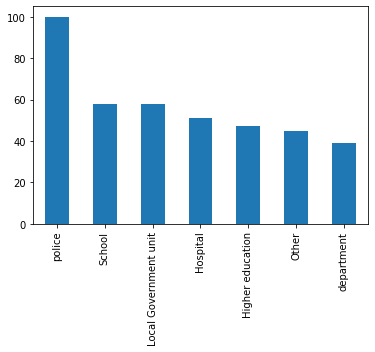

In [138]:
iForest_outlier['dept_name_group'].value_counts().plot(kind='bar');

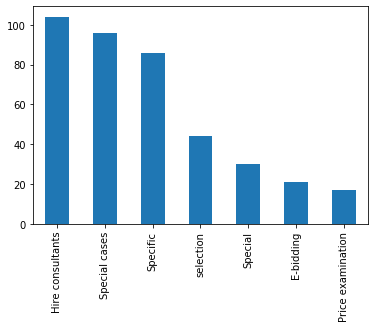

In [284]:
iForest_outlier['purchase_method_group_name_eng'].value_counts().plot(kind='bar');

In [140]:
#create spending tranche grouping
def spending_tranche(x):
    if x < 2000000: # < 2m
        return "0-2m"
    elif x < 5000000: # < 5m
        return "2m-5m"
    elif x < 10000000: # < 10m
        return "5m-10m"
    elif x < 50000000: # < 50m
        return "10m-50m"
    elif x < 100000000: # < 100m
        return "50m-100m"
    elif x < 500000000: # < 500m
        return "100m-500m"
    elif x < 1000000000: # < 1b
        return "500m-1b"    
    else:     
        return '1b+'
    
iForest_outlier['Spending_tranche'] = iForest_outlier['sum_price_agree_cleaned'].apply(spending_tranche)
df_project['Spending_tranche'] = df_project['sum_price_agree_cleaned'].apply(spending_tranche)

C:\Users\v-krvibh\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-1 = outliers
 1 = inliers


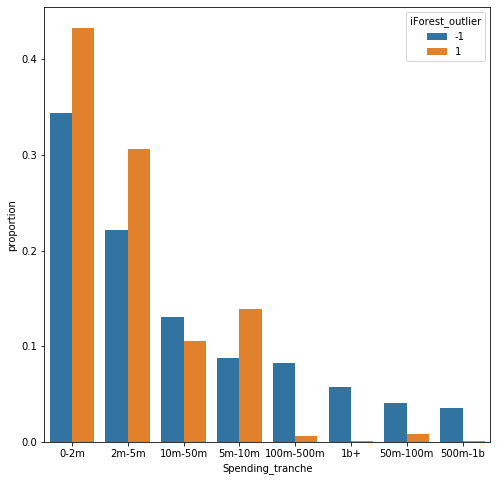

In [146]:
import seaborn as sns
from matplotlib.pyplot import figure

figure( figsize=(8,8))
x, y, hue = "Spending_tranche", "proportion", "iForest_outlier"
hue_order = ["Male", "Female"]

(df_project[x]
 .groupby(df_project[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

print('-1 = outliers')
print(' 1 = inliers')

Recall that Iforest looks for "few and different" data points. This would mean that data points with very high and very low spending are more likely to be outliers, which makes senses. However, they are also less interesting because we can usually spot those points manually. So, I will only be looking at the outlier with spending between 5m to 1b

In [147]:
iForest_outlier_mid = iForest_outlier[iForest_outlier['sum_price_agree_cleaned'] < 1000000000]
iForest_outlier_mid = iForest_outlier_mid[iForest_outlier_mid['sum_price_agree_cleaned'] > 5000000]

Picking interesting outliers

In [159]:
iForest_outlier_mid.shape

(147, 19)

now we are able to narrow down the outliers to just a handful projects.
Then we would want to look on which category do the outliers most likely to fall into

In [254]:
iForest_outlier_example = iForest_outlier_mid
for i in ['dept_name_group','purchase_method_group_name_eng','project_status_eng','Topic_group']:
    iForest_outlier_example = iForest_outlier_example[iForest_outlier_mid[i] == iForest_outlier_example[i].value_counts().idxmax()]

C:\Users\v-krvibh\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
iForest_outlier_example.shape

(2, 19)

In [257]:
iForest_outlier_example

,project_type_name_eng,purchase_method_group_name_eng,province_eng,project_status_eng,district_eng,announce_date_eng,transaction_date_eng,project_money_cleaned,price_build_cleaned,sum_price_agree_cleaned,dept_name_eng,budget_year_cleaned,project_id,project_name,geom,dept_name_group,Topic_group,iForest_outlier,Spending_tranche
78381,buy,Special cases,Bangkok,End of contract,Dusit,NaN,7 Jun 2016,53415000,53415000,53388000,National Police Agency,2016,59056160888,ซื้อเกราะลำตัว (46.15.15.04 ) โดยวิธีกรณีพิเศษ,NaN,police,16,-1,50m-100m
78965,buy,Special cases,Bangkok,End of contract,Dusit,NaN,16 Sep 2016,35311900,35241040,35264660,National Police Agency,2016,59096184193,ซื้อสนับศอก (46.15.15.04 ) โดยวิธีกรณีพิเศษ,NaN,police,16,-1,10m-50m


In [280]:
for i in categorical_cols:
    print('Category name: ',i, ', category value ' ,iForest_outlier_example[i].unique())

Category name:  project_type_name_eng , category value  ['buy']
Category name:  purchase_method_group_name_eng , category value  ['Special cases']
Category name:  project_status_eng , category value  ['End of contract']
Category name:  dept_name_group , category value  ['police']
Category name:  Topic_group , category value  [16]


In [261]:
categorical_cols

['project_type_name_eng',
 'purchase_method_group_name_eng',
 'project_status_eng',
 'dept_name_group',
 'Topic_group']

In [281]:
df_project[(df_project['project_type_name_eng'] == 'buy') 
           & (df_project['purchase_method_group_name_eng'] == 'Special cases')
           & (df_project['project_status_eng'] == 'End of contract')
           & (df_project['dept_name_group'] == 'police')
           & (df_project['Topic_group'] == 16)]

,project_type_name_eng,purchase_method_group_name_eng,province_eng,project_status_eng,district_eng,announce_date_eng,transaction_date_eng,project_money_cleaned,price_build_cleaned,sum_price_agree_cleaned,dept_name_eng,budget_year_cleaned,project_id,project_name,geom,dept_name_group,Topic_group,iForest_outlier,Spending_tranche
21523,buy,Special cases,Bangkok,End of contract,Dusit,NaN,14 Sep 2015,6300000,6300000,6259200,National Police Agency,2015,58056010347,ซื้อเกราะลำตัว (46.15.15.04 ) โดยวิธีกรณีพิเศษ,POINT(100.519873059321 13.7873113160748),police,16,1,5m-10m
78381,buy,Special cases,Bangkok,End of contract,Dusit,NaN,7 Jun 2016,53415000,53415000,53388000,National Police Agency,2016,59056160888,ซื้อเกราะลำตัว (46.15.15.04 ) โดยวิธีกรณีพิเศษ,NaN,police,16,-1,50m-100m
78965,buy,Special cases,Bangkok,End of contract,Dusit,NaN,16 Sep 2016,35311900,35241040,35264660,National Police Agency,2016,59096184193,ซื้อสนับศอก (46.15.15.04 ) โดยวิธีกรณีพิเศษ,NaN,police,16,-1,10m-50m
89911,buy,Special cases,Bangkok,End of contract,Dusit,NaN,22 Dec 2015,6715000,6715000,6674000,National Police Agency,2016,58126146908,ซื้อเกราะลำตัว (46.15.15.04 ) โดยวิธีกรณีพิเศษ,POINT(100.519873059321 13.7873113160748),police,16,1,5m-10m
